## Installing the necessary utilities

In [ ]:
# # PyG installation
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# !pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [ ]:
!pip install networkx

## Importing necessary libraries

In [ ]:
import torch
import torch_geometric
import pandas as pd
import numpy as np
import networkx as nx

In [ ]:
vers = torch.__version__
print("Torch version: ",vers)

Torch version:  2.5.1+cu121


## Importing our dataset

### Dataset

- Contains news propagation graphs extracted from Twitter
- Source and raw data: https://github.com/KaiDMML/FakeNewsNet
- Preprocessing: https://arxiv.org/pdf/2104.12259.pdf
- feature="content" --> Spacy Word2Vec + Profile features


In [ ]:
from torch_geometric.datasets import UPFD

In [ ]:
train_data = UPFD(root='data/UPFD',name = "gossipcop", feature="content", split='train')
test_data = UPFD(root='data/UPFD',name = "gossipcop", feature="content", split='test')

In [ ]:
print("Size of training dataset:" ,len(train_data))
print("Size of test dataset:" ,len(test_data))

Size of training dataset: 1092
Size of test dataset: 3826


In [ ]:
train_data[0]

Data(x=[76, 310], edge_index=[2, 75], y=[1])

## Exploratory Data analysis

In [ ]:
sample_id=1
train_data[sample_id].edge_index

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  15,  15,  17,  17,
          22,  22,  22,  22,  23,  26,  26,  26,  26,  26,  26,  26,  26,  27,
          27,  27,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
          28,  28,  28,  28,  28,  28,  28,  28,  30,  34,  34,  38,  38,  38,
          38,  39,  40,  57,  59,  65,  65,  65,  66,  68,  69,  77,  77,  79,
          79,  80,  83,  83,  83,  83,  84, 101, 110, 115, 116, 117],
        [  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
          15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
          29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  43,  44,
          45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  5

In [ ]:
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False, remove_self_loops=False):
    """
    Converts a PyTorch Geometric Data object to a NetworkX graph.

    Args:
        data (torch_geometric.data.Data): A graph object from PyTorch Geometric.
        node_attrs (list, optional): List of node attribute keys to include in the graph. Defaults to None.
        edge_attrs (list, optional): List of edge attribute keys to include in the graph. Defaults to None.
        to_undirected (bool, optional): If True, converts the graph to an undirected graph. Defaults to False.
        remove_self_loops (bool, optional): If True, removes self-loops from the graph. Defaults to False.

    Returns:
        networkx.Graph or networkx.DiGraph: A NetworkX graph.
    """
    # Create an undirected or directed graph
    G = nx.Graph() if to_undirected else nx.DiGraph()

    # Add nodes to the graph
    G.add_nodes_from(range(data.num_nodes))

    # Initialize attributes
    node_attrs = node_attrs or []
    edge_attrs = edge_attrs or []
    values = {}

    # Extract node and edge attributes from the data object
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()  # Convert tensor to a list
        else:
            values[key] = item
        # Handle single-element lists or tuples
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = values[key][0]

    # Add edges to the graph
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue  # Avoid duplicate edges in undirected graphs
        if remove_self_loops and u == v:
            continue  # Skip self-loops if specified
        G.add_edge(u, v)
        # Add edge attributes
        for key in edge_attrs:
            G[u][v][key] = values[key][i]

    # Add node attributes
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})

    return G


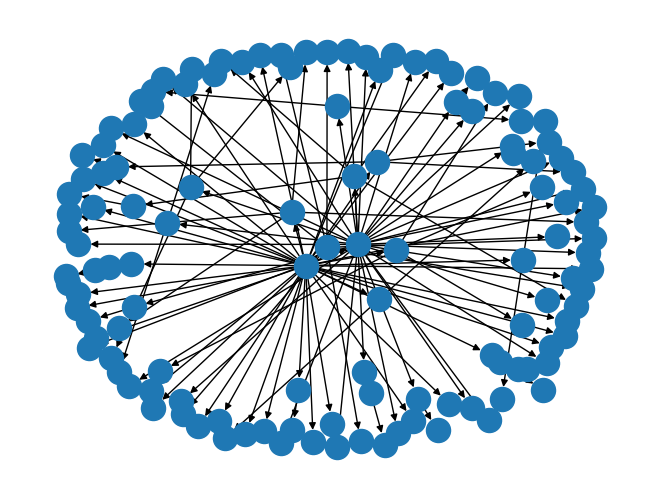

In [ ]:
nx.draw(to_networkx(train_data[sample_id]))

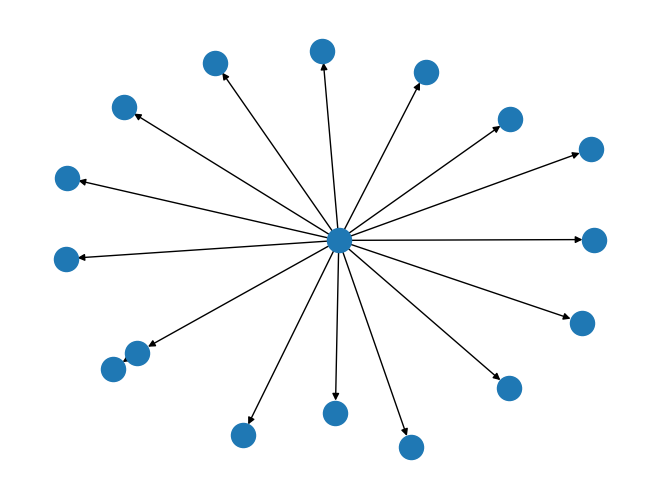

In [ ]:
nx.draw(to_networkx(test_data[sample_id]))

In [ ]:
print(train_data[sample_id].x.shape)
train_data[sample_id].x

torch.Size([125, 310])


tensor([[0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529],
        [0.4610, 0.4544, 0.6279,  ..., 0.2055, 0.1667, 0.2500],
        [0.4461, 0.4728, 0.4978,  ..., 0.8356, 0.0556, 0.0000],
        ...,
        [0.5574, 0.4934, 0.5588,  ..., 0.3562, 0.0556, 0.2647],
        [0.5274, 0.5889, 0.4425,  ..., 0.9589, 0.1111, 0.1176],
        [0.5220, 0.5120, 0.4817,  ..., 0.6874, 0.1023, 0.1529]])

### Class Distribution

<Axes: >

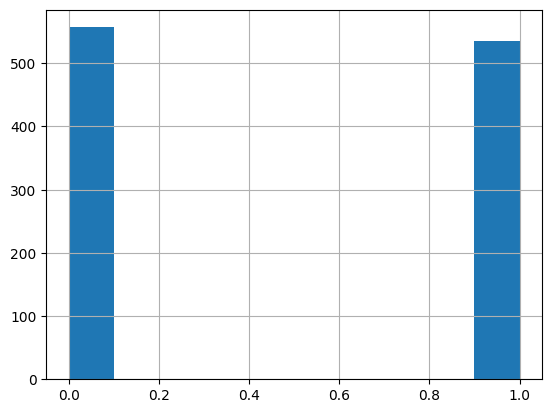

In [ ]:
labels = [data.y.item() for i, data in enumerate(train_data)]
data = pd.DataFrame(labels, columns=['labels'])
data["labels"].hist()

It is generally observed that such datasets have a huge class imbalance; however in this case, it doesn't seem to be a problem.

### Data Loader

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Model & Training

From our evaluation above, we see that our graph is directed.

Therefore, it will only share information from the root.

In [ ]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear


In [ ]:
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2*hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # According to UPFD paper: Include raw word2vec embeddings of news
        # This is done per graph in the batch
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        # root is e.g. [   0,   14,   94,  171,  230,  302, ... ]
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)

GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve
)
import pandas as pd
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()



In [ ]:
# Training function
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Testing function
@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(torch.reshape(out, (-1,)), data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(torch.reshape(out, (-1,)))
        all_labels.append(data.y.float())

    # Calculate Metrics
    acc, f1, precision, recall, roc_auc = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), acc, f1, precision, recall, roc_auc, all_preds, all_labels


# Metric calculation function
def metrics(preds, gts):
    preds = torch.round(torch.cat(preds)).cpu()
    gts = torch.cat(gts).cpu()
    acc = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds)
    precision = precision_score(gts, preds)
    recall = recall_score(gts, preds)
    roc_auc = roc_auc_score(gts, preds)
    return acc, f1, precision, recall, roc_auc


# Confusion Matrix plot
def plot_confusion_matrix(preds, gts):
    preds = torch.round(torch.cat(preds)).cpu()
    gts = torch.cat(gts).cpu()
    cm = confusion_matrix(gts, preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


# ROC Curve plot
def plot_roc_curve(preds, gts):
    preds = torch.cat(preds).cpu().numpy()
    gts = torch.cat(gts).cpu().numpy()
    fpr, tpr, _ = roc_curve(gts, preds)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 01 | TrainLoss: 0.7262 | TestLoss: 0.7068 | Accuracy: 0.4992 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.5000
Epoch: 02 | TrainLoss: 0.6950 | TestLoss: 0.7152 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000
Epoch: 03 | TrainLoss: 0.6959 | TestLoss: 0.6905 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 04 | TrainLoss: 0.6920 | TestLoss: 0.6865 | Accuracy: 0.4992 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 05 | TrainLoss: 0.6920 | TestLoss: 0.7490 | Accuracy: 0.4992 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.5000
Epoch: 06 | TrainLoss: 0.7014 | TestLoss: 0.6859 | Accuracy: 0.5013 | Precision: 0.5010 | Recall: 1.0000 | F1: 0.6676 | ROC-AUC: 0.5005


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 07 | TrainLoss: 0.6972 | TestLoss: 0.7452 | Accuracy: 0.4992 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.5000
Epoch: 08 | TrainLoss: 0.6997 | TestLoss: 0.6867 | Accuracy: 0.4995 | Precision: 1.0000 | Recall: 0.0005 | F1: 0.0010 | ROC-AUC: 0.5003


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 09 | TrainLoss: 0.6898 | TestLoss: 0.8357 | Accuracy: 0.4992 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 10 | TrainLoss: 0.7063 | TestLoss: 0.6825 | Accuracy: 0.4992 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.5000
Epoch: 11 | TrainLoss: 0.6784 | TestLoss: 0.7612 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000
Epoch: 12 | TrainLoss: 0.6872 | TestLoss: 0.7258 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000
Epoch: 13 | TrainLoss: 0.6958 | TestLoss: 0.7119 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 14 | TrainLoss: 0.6782 | TestLoss: 0.6820 | Accuracy: 0.4992 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.5000
Epoch: 15 | TrainLoss: 0.6815 | TestLoss: 0.6714 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000
Epoch: 16 | TrainLoss: 0.6665 | TestLoss: 0.6315 | Accuracy: 0.8636 | Precision: 0.7946 | Recall: 0.9812 | F1: 0.8781 | ROC-AUC: 0.8634
Epoch: 17 | TrainLoss: 0.6336 | TestLoss: 0.6125 | Accuracy: 0.8905 | Precision: 0.8373 | Recall: 0.9697 | F1: 0.8987 | ROC-AUC: 0.8904
Epoch: 18 | TrainLoss: 0.6424 | TestLoss: 0.6694 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000
Epoch: 19 | TrainLoss: 0.6429 | TestLoss: 0.6073 | Accuracy: 0.6127 | Precision: 0.9977 | Recall: 0.2270 | F1: 0.3699 | ROC-AUC: 0.6133
Epoch: 20 | TrainLoss: 0.5901 | TestLoss: 1.0711 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000
Epoch: 21 | TrainLoss: 0.6798 | TestLoss: 0.6782

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch: 22 | TrainLoss: 0.5549 | TestLoss: 0.8809 | Accuracy: 0.4992 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000 | ROC-AUC: 0.5000
Epoch: 23 | TrainLoss: 0.6023 | TestLoss: 0.5422 | Accuracy: 0.6973 | Precision: 0.9884 | Recall: 0.4003 | F1: 0.5698 | ROC-AUC: 0.6978
Epoch: 24 | TrainLoss: 0.5513 | TestLoss: 0.5554 | Accuracy: 0.6215 | Precision: 0.5697 | Recall: 0.9979 | F1: 0.7253 | ROC-AUC: 0.6209
Epoch: 25 | TrainLoss: 0.5261 | TestLoss: 0.9680 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000
Epoch: 26 | TrainLoss: 0.5932 | TestLoss: 0.5974 | Accuracy: 0.5112 | Precision: 0.5061 | Recall: 1.0000 | F1: 0.6720 | ROC-AUC: 0.5105
Epoch: 27 | TrainLoss: 0.5299 | TestLoss: 0.7591 | Accuracy: 0.5008 | Precision: 0.5008 | Recall: 1.0000 | F1: 0.6674 | ROC-AUC: 0.5000
Epoch: 28 | TrainLoss: 0.5476 | TestLoss: 0.4567 | Accuracy: 0.8625 | Precision: 0.9597 | Recall: 0.7573 | F1: 0.8466 | ROC-AUC: 0.8627
Epoch: 29 | TrainLoss: 0.4663 | TestLoss: 0.4570

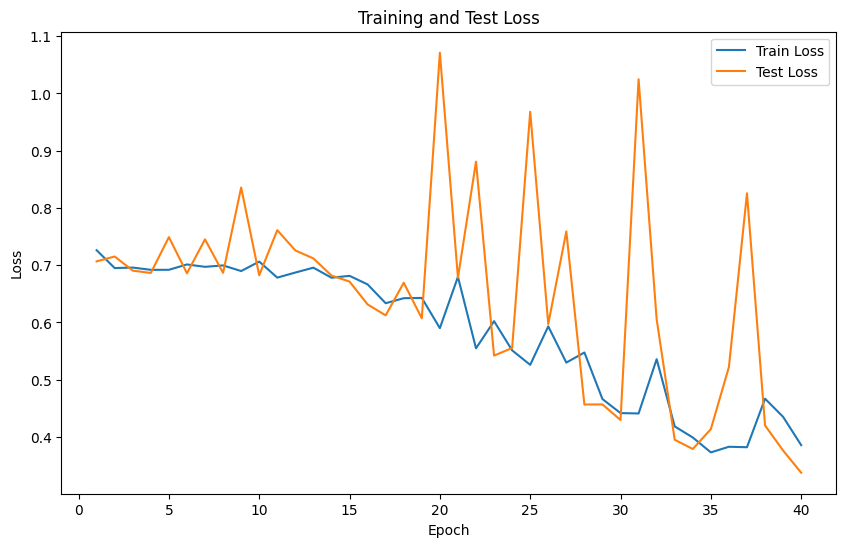

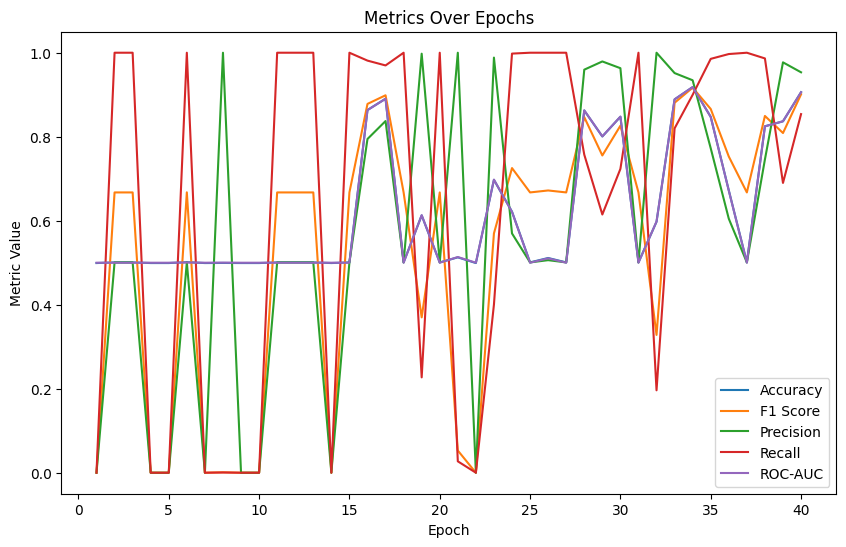

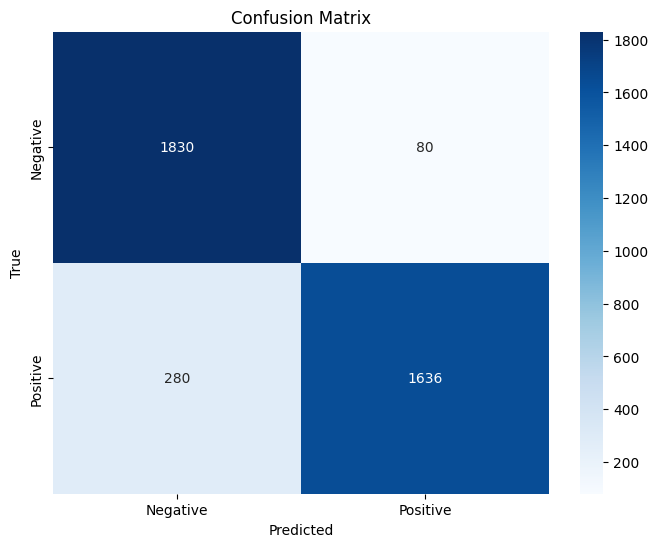

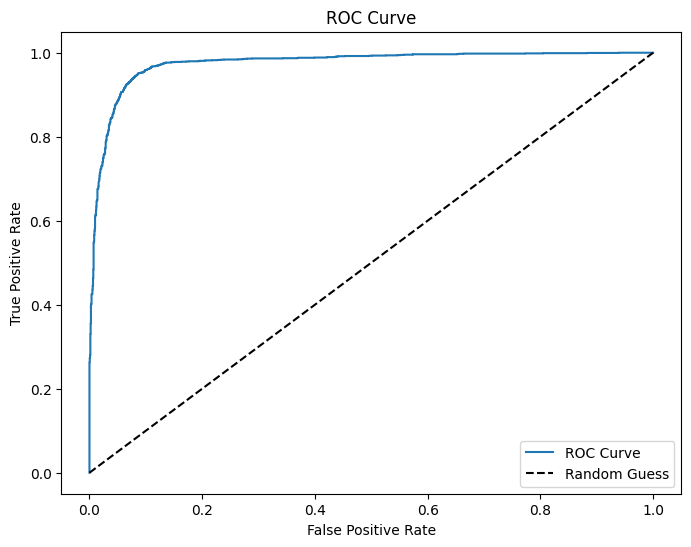

   pred_logit  pred  true
0    0.699477   1.0     1
1    0.507549   1.0     1
2    0.270993   0.0     0
3    0.526134   1.0     1
4    0.092196   0.0     0
5    0.261437   0.0     0
6    0.205597   0.0     0
7    0.805393   1.0     1
8    0.095358   0.0     0
9    0.196156   0.0     0


In [ ]:
# Training loop with metrics and logging
train_losses, test_losses = [], []
accuracies, f1s, precisions, recalls, roc_aucs = [], [], [], [], []

for epoch in range(1, 41):  # 40 epochs
    train_loss = train(epoch)
    test_loss, acc, f1, precision, recall, roc_auc, all_preds, all_labels = test(epoch)

    # Logging
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(acc)
    f1s.append(f1)
    precisions.append(precision)
    recalls.append(recall)
    roc_aucs.append(roc_auc)

    print(f'Epoch: {epoch:02d} | TrainLoss: {train_loss:.4f} | TestLoss: {test_loss:.4f} | '
          f'Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}')

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 41), train_losses, label='Train Loss')
plt.plot(range(1, 41), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plot metrics
plt.figure(figsize=(10, 6))
plt.plot(range(1, 41), accuracies, label='Accuracy')
plt.plot(range(1, 41), f1s, label='F1 Score')
plt.plot(range(1, 41), precisions, label='Precision')
plt.plot(range(1, 41), recalls, label='Recall')
plt.plot(range(1, 41), roc_aucs, label='ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Metrics Over Epochs')
plt.legend()
plt.show()

# Evaluate final predictions
plot_confusion_matrix(all_preds, all_labels)
plot_roc_curve(all_preds, all_labels)

# Display prediction dataframe
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().cpu().numpy()[:, 0]
    df["pred"] = torch.round(pred).detach().cpu().numpy()[:, 0]
    df["true"] = data.y.cpu().numpy()
    print(df.head(10))
    break
